In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [2]:
#plt.style.use('ggplot')
#plt.xkcd()

In [3]:
df = pd.read_csv("../data/HEC_processed.csv", parse_dates=[0], index_col=0)

In [4]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [5]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
len(df)

2075259

In [7]:
df.describe()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


欠損値の線形補完

In [8]:
df.interpolate(method="time",inplace=True)

## 今回は2007年１月のデータだけを使います。

In [9]:
span_whole = pd.date_range(start=dt.datetime(2007, 1, 1), end=dt.datetime(2007, 3, 1), freq="T")
span_train =pd.date_range(start=dt.datetime(2007, 1, 1), end=dt.datetime(2007, 2, 1), freq="T")
span_test =pd.date_range(start=dt.datetime(2007, 1, 21), end=dt.datetime(2007, 3, 1), freq="T")

In [10]:
type(span_whole)

pandas.core.indexes.datetimes.DatetimeIndex

In [11]:
ts_gap = df["Global_active_power"][ span_whole]

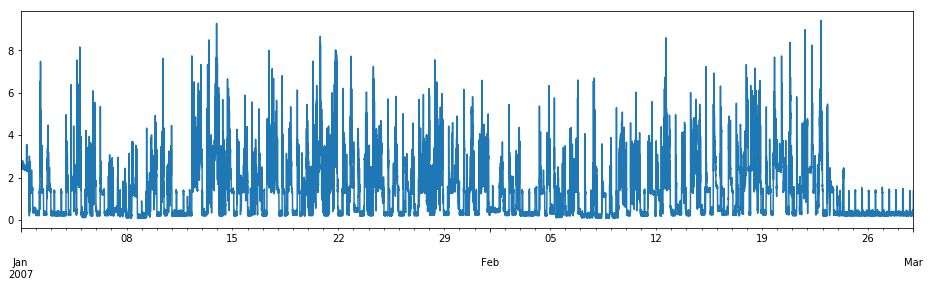

In [12]:
plt.figure(figsize=(16, 4))
ts_gap.plot()
plt.show()

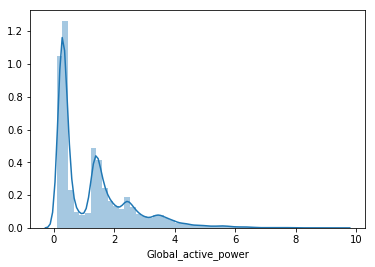

In [13]:
sns.distplot(ts_gap)
plt.show()

In [14]:
len(ts_gap)

84961

## 差分変換

In [15]:
ts_gap_diff= ts_gap.diff()

In [16]:
ts_gap_diff=ts_gap_diff.dropna()

In [17]:
print(len(ts_gap_diff))

84960


In [18]:
len(span_whole)

84961

In [19]:
ts_gap_diff = pd.Series(ts_gap_diff, index=span_whole[1:])

In [20]:
ts_gap_diff.head()

2007-01-01 00:01:00   -0.028
2007-01-01 00:02:00   -0.002
2007-01-01 00:03:00    0.000
2007-01-01 00:04:00    0.004
2007-01-01 00:05:00   -0.004
Freq: T, Name: Global_active_power, dtype: float64

In [23]:
np.any(ts_gap_diff.isnull())

False

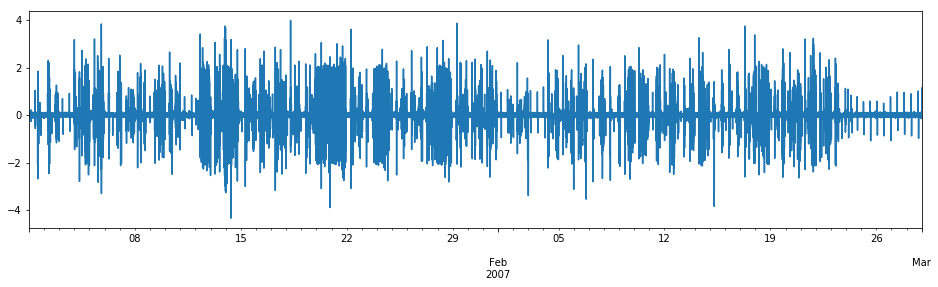

In [24]:
plt.figure(figsize=(16, 4))
ts_gap_diff.plot()
plt.show()

In [28]:
span_train = span_train[1:]

# ARIMA modelによる予測

In [29]:
ts_gap_diff[span_train].size

44640

In [30]:
model = ARIMA(ts_gap_diff[span_train].values, dates= span_train, freq="T", order=(5, 1, 5)).fit(ic="aic")

/Users/fukuchi/.pyenv/versions/3.7.3/envs/env_ML/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/fukuchi/.pyenv/versions/3.7.3/envs/env_ML/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [31]:
60*24*30

43200

In [32]:
pred_ar = model.predict(start=str(span_test[0]), 
                        end=str(span_test[-1]), 
                           dynamic=False)

/Users/fukuchi/.pyenv/versions/3.7.3/envs/env_ML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [33]:
len(pred_ar)

56161

In [34]:
print(len(pred_ar))
print(len(span_test))

56161
56161


In [57]:
ts_pred = pd.Series(pred_ar, index=span_test)

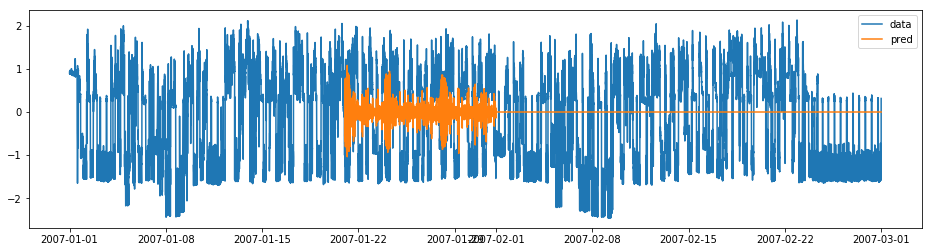

In [58]:
plt.figure(figsize=(16, 4))
plt.plot(ts_gap_diff.index, ts_gap_diff.values, label="data")
plt.plot(ts_pred.index, ts_pred.values, label="pred")
plt.legend()
plt.show()

拡大してみる

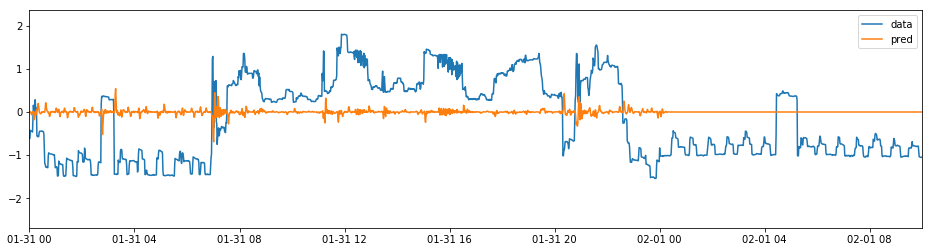

In [59]:
plt.figure(figsize=(16, 4))
plt.plot(ts_gap_diff.index, ts_gap_diff.values, label="data")
plt.plot(ts_pred.index, ts_pred.values, label="pred")
plt.xlim(str(dt.datetime(2007, 1, 31)), str(dt.datetime(2007, 2, 1, 10)))
plt.legend()
plt.show()

もっと拡大してみる

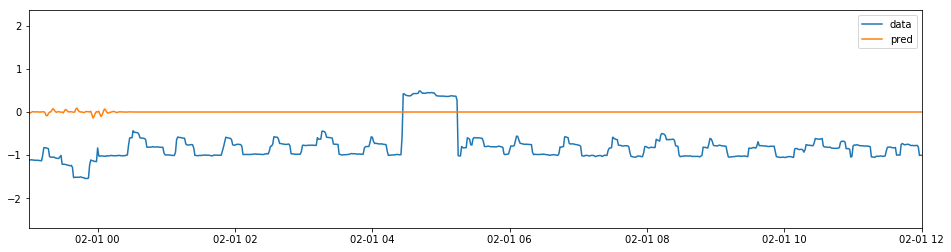

In [62]:
plt.figure(figsize=(16, 4))
plt.plot(ts_gap_diff.index, ts_gap_diff.values, label="data")
plt.plot(ts_pred.index, ts_pred.values, label="pred")
plt.xlim(str(dt.datetime(2007, 1, 31, 23)), str(dt.datetime(2007, 2, 1, 12)))
plt.legend()
plt.show()